1. Spielfeld in 3 Zonen teilen
2. Positionsdaten filtern
   1. Horizontal
   2. vertikal
3. Dribblings raussuchen über Flügel
4. Abschluss im letzten 3. des Spielfeldes

In [1]:
import sys
import subprocess

# Liste der benötigten Pakete
pakete = ["numpy", "pandas", "matplotlib", "socceraction" , "pygam", "warnings"]  # Hier deine Pakete eintragen

# Installiere Pakete, falls sie nicht vorhanden sind
for paket in pakete:
    try:
        __import__(paket)
    except ImportError:
        print(f"{paket} wird installiert...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", paket])

In [2]:
import pandas as pd
import socceraction.spadl as spadl
import warnings
import numpy as np
import matplotlib.pyplot as plt
from pygam import LogisticGAM, s, f

In [3]:
# Ignore warnings
warnings.filterwarnings(
  action="ignore", 
  message="credentials were not supplied. open data access only"
)
warnings.simplefilter(
  action='ignore', 
  category=pd.errors.PerformanceWarning
)
pd.set_option('future.no_silent_downcasting', True)

warnings.filterwarnings(
    "ignore",
    message="A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method."
)

In [4]:
spadl_h5 = ".\\xSuccess\\top5_15-16_spadl\\match_data.h5"

with pd.HDFStore(spadl_h5) as spadlstore:
    # Spiele laden
    games = spadlstore["games"]
    
    # Du kannst auch teams / players laden, wenn du sie für später brauchst
    teams = spadlstore["teams"]
    players = spadlstore["players"]
    
    all_actions_list = []
    
    # Über alle Spiele iterieren
    for gid in games.game_id:
        df_actions = spadlstore[f"actions/game_{gid}"]
        # Ggf. noch die 'game_id' explizit als Spalte hinzufügen,
        # falls du sie später brauchst.
        df_actions["game_id"] = gid
        
        all_actions_list.append(df_actions)
    
    # Zu einem großen DataFrame zusammenfügen
    all_actions = pd.concat(all_actions_list, ignore_index=True)

all_actions["game_id"].count()

3639858

In [5]:
max_end_x = all_actions["end_x"].max()
max_end_y = all_actions["end_y"].max()

print("Maximaler Wert in end_x:", max_end_x)
print("Maximaler Wert in end_y:", max_end_y)


Maximaler Wert in end_x: 105.0
Maximaler Wert in end_y: 68.0


In [6]:
all_actions = (
    all_actions
    .merge(spadl.actiontypes_df(), how='left', on='type_id')
    .merge(spadl.results_df(), how='left', on='result_id')
    .merge(spadl.bodyparts_df(), how='left', on='bodypart_id')
)

Aktions-Distanz in Metern berechnen, da die X und Y Koordinaten in Metern angegeben sind

Max end_x: 105

Max end_y: 68

In [7]:
all_actions["action_distance"] = np.sqrt(
    (all_actions["end_x"] - all_actions["start_x"])**2 +
    (all_actions["end_y"] - all_actions["start_y"])**2
)

In [8]:
all_actions["type_name"].unique()

array(['pass', 'dribble', 'throw_in', 'bad_touch', 'interception',
       'freekick_short', 'foul', 'cross', 'shot', 'goalkick', 'take_on',
       'tackle', 'clearance', 'keeper_punch', 'corner_crossed',
       'freekick_crossed', 'keeper_save', 'keeper_claim', 'corner_short',
       'shot_freekick', 'shot_penalty'], dtype=object)

In [9]:
all_actions["result_name"].unique()

array(['success', 'fail', 'offside', 'yellow_card', 'owngoal', 'red_card'],
      dtype=object)

In [35]:
filtered_row = all_actions[all_actions["result_name"] == "owngoal"].head(1)
filtered_row

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,action_distance
2289,3890561,b261906f-e190-4b95-991b-315345ca5c05,2,2597.228,175,5537.0,7.875,39.78,7.875,39.78,19,3,0,2289,bad_touch,owngoal,foot,0.0


0 == fail \
1 == sucess\
2 == offside\
3 == owngoal\
4 == yellow_card\
5 == red_card

Alle Ergebnisse werden auf 0 == fail gesetzt bis auf die 1 == success

In [36]:
all_actions["result_id"] = np.where(all_actions["result_id"] == 1, 1, 0)


In [37]:
all_actions["result_id"].unique()

array([1, 0])

In [10]:
success_count = all_actions[all_actions['result_id'] == 1].shape[0]
unsuccess_count = all_actions[all_actions['result_id'] == 0].shape[0]

In [11]:
success_count

3013210

In [12]:
unsuccess_count

611964

In [13]:
success_dribbles_count = all_actions[(all_actions['result_id'] == 1) & (all_actions["type_name"] == "dribble")].shape[0]
unsuccess_dribbles_count = all_actions[(all_actions['result_id'] == 0) & (all_actions["type_name"] == "dribble")].shape[0]

In [14]:
success_dribbles_count

1422860

In [15]:
unsuccess_dribbles_count

0

Gibt es wirklich keine gescheiterten Dribblings?

In [16]:
success_pass_count = all_actions[(all_actions['result_id'] == 1) & (all_actions["type_name"] == "pass")].shape[0]
unsuccess_pass_count = all_actions[(all_actions['result_id'] == 0) & (all_actions["type_name"] == "pass")].shape[0]

In [17]:
success_pass_count

1218542

In [18]:
unsuccess_pass_count

312379

In [19]:
all_actions.head()

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,action_distance
0,3890561,644e16d7-10ca-45f0-8128-fc0055d6f753,1,0.482,175,8387.0,52.9375,34.340,52.2375,36.210,0,1,4,0,pass,success,foot_left,1.996722
1,3890561,329a1879-2521-4614-8c68-b4798b0e5d23,1,0.935,175,5460.0,52.2375,36.210,51.5375,35.870,21,1,0,1,dribble,success,foot,0.778203
2,3890561,77e2ddaf-6de3-49e7-a318-7d765799b543,1,1.015,175,5460.0,51.5375,35.870,46.7250,32.640,0,1,4,2,pass,success,foot_left,5.795952
3,3890561,1b91a029-f722-4b0d-b9d5-53cdc776f9e3,1,2.167,175,6039.0,46.7250,32.640,45.3250,30.005,21,1,0,3,dribble,success,foot,2.983827
4,3890561,2c51f271-c812-45af-896b-06f49a14a5bb,1,2.954,175,6039.0,45.3250,30.005,29.5750,15.725,0,1,5,4,pass,success,foot_right,21.259842


Dribbling Tabelle

In [20]:
# 1) Nur Dribblings herausfiltern
dribbles = all_actions[all_actions["type_name"] == "dribble"].copy()

In [21]:
# 2) Spielfeld in 3 horizontale Zonen anhand der Startposition (start_y) einteilen
#    y <= 22         => Zone 1
#    22 < y <= 45    => Zone 2
#    y > 45          => Zone 3

def get_zone(y):
    if y <= 22:
        return 1
    elif y <= 45:
        return 2
    else:
        return 3

dribbles["zone"] = dribbles["start_y"].apply(get_zone)

In [22]:
# 3) Die Länge der Dribblings bestimmen (euklidische Distanz zwischen Start- und Endkoordinate)

dribbles["dribble_distance"] = np.sqrt(
    (dribbles["end_x"] - dribbles["start_x"])**2 +
    (dribbles["end_y"] - dribbles["start_y"])**2
)


![alt text](image.png)

In [23]:
dribbles.head()

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,action_distance,zone,dribble_distance
1,3890561,329a1879-2521-4614-8c68-b4798b0e5d23,1,0.935,175,5460.0,52.2375,36.210,51.5375,35.870,21,1,0,1,dribble,success,foot,0.778203,2,0.778203
3,3890561,1b91a029-f722-4b0d-b9d5-53cdc776f9e3,1,2.167,175,6039.0,46.7250,32.640,45.3250,30.005,21,1,0,3,dribble,success,foot,2.983827,2,2.983827
5,3890561,4e93eb34-ac12-4a24-bcfa-e17d853c8951,1,4.344,175,5537.0,29.5750,15.725,29.5750,15.810,21,1,0,5,dribble,success,foot,0.085000,1,0.085000
7,3890561,0d3f0101-1b31-46f2-86d6-67b4df6967db,1,8.451,175,12321.0,32.3750,48.280,33.2500,49.555,21,1,0,7,dribble,success,foot,1.546367,3,1.546367
9,3890561,87748ce9-72e9-4886-9d81-87160ff28fd5,1,12.070,175,9396.0,31.6750,38.250,34.2125,40.630,21,1,0,9,dribble,success,foot,3.478981,2,3.478981


In [24]:
# Zähle die erfolgreichen und misslungenen Dribblings
#success_count = dribbles["successful"].sum()
success_count = dribbles[dribbles['result_id'] == 1].shape[0]
unsuccess_count = dribbles[dribbles['result_id'] == 0].shape[0]

success_count

1422860

In [25]:
unsuccess_count

0

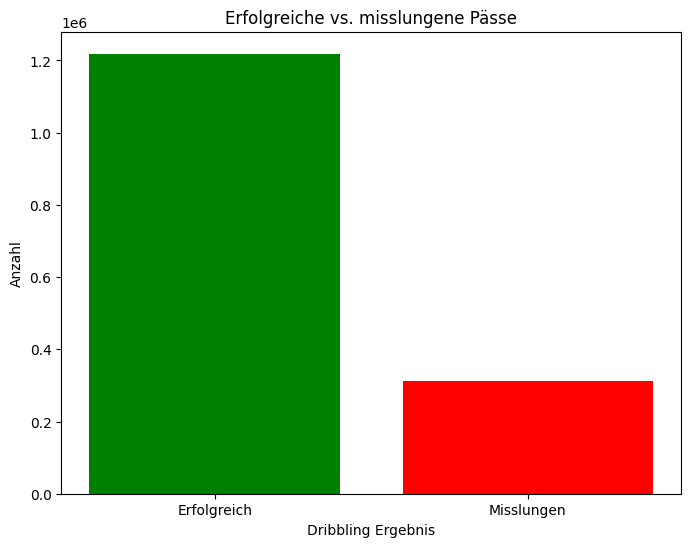

In [26]:
# Erstelle Labels und Werte
labels = ["Erfolgreich", "Misslungen"]
counts = [success_pass_count, unsuccess_pass_count]

# Plotten
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=["green", "red"])
plt.xlabel("Dribbling Ergebnis")
plt.ylabel("Anzahl")
plt.title("Erfolgreiche vs. misslungene Pässe")
plt.show()

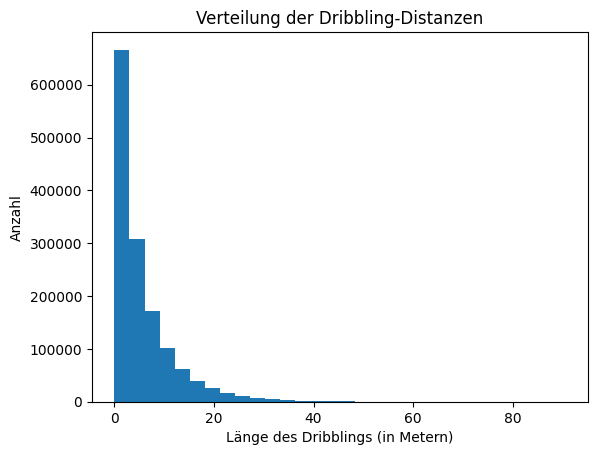

In [27]:
plt.hist(dribbles["dribble_distance"], bins=30)
plt.xlabel("Länge des Dribblings (in Metern)")
plt.ylabel("Anzahl")
plt.title("Verteilung der Dribbling-Distanzen")
plt.show()

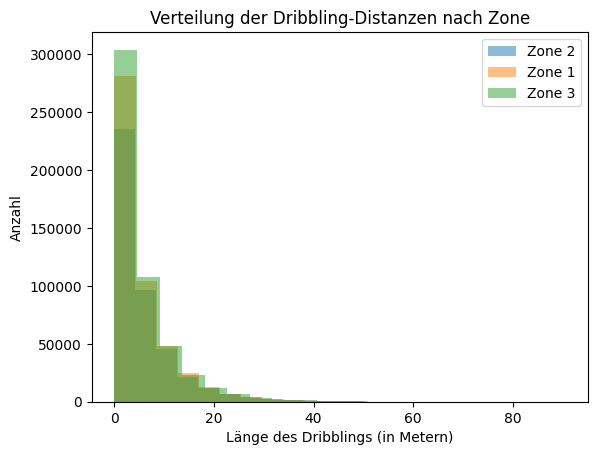

In [28]:
zones = dribbles["zone"].unique()  # Liste der vorhandenen Zonen

for z in zones:
    subset = dribbles[dribbles["zone"] == z]
    plt.hist(
        subset["dribble_distance"], 
        bins=20, 
        alpha=0.5,              # Transparenz, damit Überlappungen sichtbar werden
        label=f"Zone {z}"
    )

plt.xlabel("Länge des Dribblings (in Metern)")
plt.ylabel("Anzahl")
plt.title("Verteilung der Dribbling-Distanzen nach Zone")
plt.legend()
plt.show()

Alle Events in einem Spiel betrachten

In [29]:
game_3890561 = all_actions[all_actions["game_id"] == 3890561]
game_3890561

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,action_distance
0,3890561,644e16d7-10ca-45f0-8128-fc0055d6f753,1,0.482,175,8387.0,52.9375,34.340,52.2375,36.210,0,1,4,0,pass,success,foot_left,1.996722
1,3890561,329a1879-2521-4614-8c68-b4798b0e5d23,1,0.935,175,5460.0,52.2375,36.210,51.5375,35.870,21,1,0,1,dribble,success,foot,0.778203
2,3890561,77e2ddaf-6de3-49e7-a318-7d765799b543,1,1.015,175,5460.0,51.5375,35.870,46.7250,32.640,0,1,4,2,pass,success,foot_left,5.795952
3,3890561,1b91a029-f722-4b0d-b9d5-53cdc776f9e3,1,2.167,175,6039.0,46.7250,32.640,45.3250,30.005,21,1,0,3,dribble,success,foot,2.983827
4,3890561,2c51f271-c812-45af-896b-06f49a14a5bb,1,2.954,175,6039.0,45.3250,30.005,29.5750,15.725,0,1,5,4,pass,success,foot_right,21.259842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2299,3890561,15ed9cd8-5ea3-4920-9289-1be7d145b317,2,2755.622,175,6039.0,40.5125,45.390,40.9500,45.985,21,1,0,2299,dribble,success,foot,0.738533
2300,3890561,6a80ebda-aabe-4591-9a6e-5f1dc3f4a580,2,2756.994,175,6039.0,40.9500,45.985,49.2625,35.020,0,1,5,2300,pass,success,foot_right,13.759683
2301,3890561,54a4120e-04f2-4f64-b737-f5f7431d1c68,2,2758.132,175,8387.0,49.2625,35.020,48.3875,36.720,21,1,0,2301,dribble,success,foot,1.911969
2302,3890561,5fd7f069-c62c-4110-b3d5-e3ab54281742,2,2759.102,175,8387.0,48.3875,36.720,30.3625,39.695,0,1,4,2302,pass,success,foot_left,18.268860


Reihen sich alle Aktionen nahtlos aneinander?

Falls ja, kann die Geschwindigkeit der Aktion berechnet werden mit der Euklidischen Distanz durch das Zeitdelta zwischen dem Start dieser Aktion und dem Start der nächsten Aktion

Besonderheiten sind, Tore, misslungene Torschüsse, Abseits, Foulspiel, Einwurf